
### ***Importing Necessary Libraries***

In [25]:
import os
import json
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### ***Setting Up Kaggle API Credentials***

In [26]:
kaggle_dictionary = json.load(open("kaggle.json"))
os.environ["KAGGLE_USERNAME"] = kaggle_dictionary["username"]
os.environ["KAGGLE_KEY"] = kaggle_dictionary["key"]

**Downloading the Dataset from Kaggle**

In [27]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


**Extracting the Dataset**

In [28]:
with zipfile.ZipFile("imdb-dataset-of-50k-movie-reviews.zip", "r") as zip_ref:
    zip_ref.extractall()

**Loading the Dataset**

In [29]:
data = pd.read_csv("IMDB Dataset.csv")

In [30]:
# Displayed the shape of the dataset (number of rows, number of columns)
print(f"Dataset Shape: {data.shape}")

Dataset Shape: (50000, 2)


In [31]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### ***Exploratory Data Analysis (EDA)***

**Imported Required Libraries for EDA**

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

**Checking for Missing Values**

In [33]:
# Checked for missing values in the dataset
missing_values = data.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 review       0
sentiment    0
dtype: int64


**Sentiment Distribution (Positive vs. Negative)**

<ipython-input-34-90451a8e3319>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["sentiment"], palette="coolwarm")


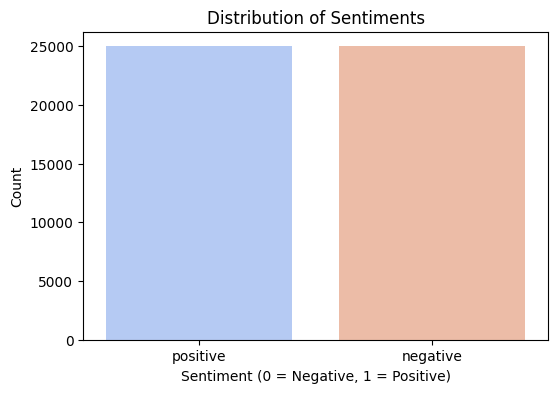

In [34]:
# Count of the number of positive and negative reviews
plt.figure(figsize=(6, 4))
sns.countplot(x=data["sentiment"], palette="coolwarm")
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.show()


**Length of Reviews vs. Sentiment**

<ipython-input-36-1600995f8807>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data["sentiment"], y=data["word_count"], palette="coolwarm")


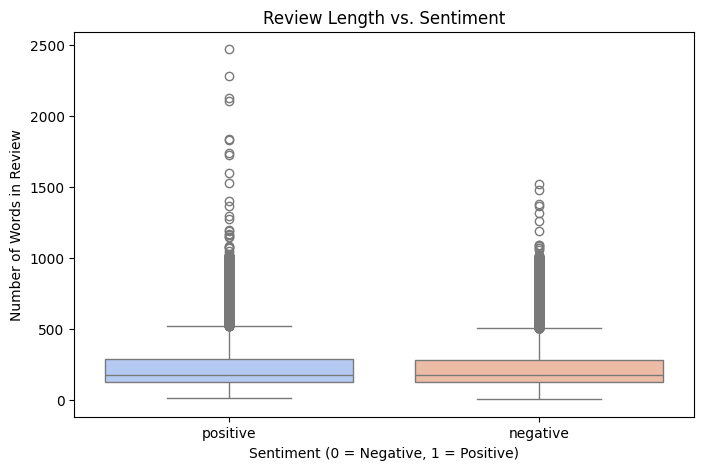

In [36]:
# Computed the number of words in each review
data["word_count"] = data["review"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
sns.boxplot(x=data["sentiment"], y=data["word_count"], palette="coolwarm")
plt.title("Review Length vs. Sentiment")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Number of Words in Review")
plt.show()


- *This checks whether longer reviews are more likely to be positive or negative.*

- *Sometimes, negative reviews are longer because people explain why they disliked the movie*.

### ***Data Preprocessing***

In [37]:
# Checked class distribution (number of positive vs. negative reviews)
print(data["sentiment"].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [38]:
# Encoded target labels: Convert 'positive' to 1 and 'negative' to 0
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

<ipython-input-38-a5ac2b0eec3e>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)


In [39]:
# Displayed the updated dataset to verify changes
data.head()

,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


### ***Splitting Data into Training and Testing Sets***

In [40]:
# Splitted Data into Training and Testing Sets
# 80% of data for training, 20% for testing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [41]:
# Displayed the size of the training and testing sets
print(f"Training Data Shape: {train_data.shape}")
print(f"Testing Data Shape: {test_data.shape}")

Training Data Shape: (40000, 3)
Testing Data Shape: (10000, 3)


### ***Text Tokenization and Sequence Padding***

In [43]:
# Tokenizing the text data to convert words into numerical indices
tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary size to 5000 words
tokenizer.fit_on_texts(train_data["review"])

In [44]:
# Convert text to sequences of numerical indices and pad them to uniform length (200 words)
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [45]:
# Target labels (sentiments) for training and testing
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

### ***Building the LSTM Model***

In [47]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=120, input_length=200),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation="sigmoid")
])

# Built the model explicitly
model.build(input_shape=(None, 200))

# Displayed the model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 120)            │         600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         127,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 727,617 (2.78 MB)

 Trainable params: 727,617 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

**Compiling the Model**

In [48]:
# Used Adam optimizer and binary cross-entropy loss since this is a binary classification task
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

**Training the Model**

In [50]:
# Trained the model for 5 epochs with a batch size of 64
model.fit(
    X_train, Y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 215s 431ms/step - accuracy: 0.7983 - loss: 0.4506 - val_accuracy: 0.8429 - val_loss: 0.3595
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 258s 424ms/step - accuracy: 0.8579 - loss: 0.3464 - val_accuracy: 0.8070 - val_loss: 0.4317
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 257s 415ms/step - accuracy: 0.8611 - loss: 0.3361 - val_accuracy: 0.8721 - val_loss: 0.3073
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 263s 416ms/step - accuracy: 0.8977 - loss: 0.2602 - val_accuracy: 0.8640 - val_loss: 0.3340
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 270s 433ms/step - accuracy: 0.9141 - loss: 0.2254 - val_accuracy: 0.8769 - val_loss: 0.3358


### ***Model Evaluation***

In [51]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 123ms/step - accuracy: 0.8763 - loss: 0.3240
Test Loss: 0.31704604625701904
Test Accuracy: 0.882099986076355


### ***Sentiment Prediction Function***

In [52]:
def predict_sentiment(review):
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "Positive" if prediction[0][0] > 0.5 else "Negative"
  return sentiment

**Testing the Sentiment Prediction Function**

In [53]:
new_review = "This movie was fantastic. I loved it."
sentiment = predict_sentiment(new_review)
print(f"Sentiment of the review: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
Sentiment of the review: Positive
